#### Authors: Jakidxav, Dennis Hartmann <br/>
Date: 04.03.2019 Revised DLH 01.05.2024<br/>
Description: Program to compute linear trends of GISSTemp Global Temperature Record. <br/>
New Description: Program to compute the confidence limits on each decade starting from the latest or earliest. <br/>


*** Homework instructions: *** <br/>
NOTE:  You need some helper programs in  process_giss_global_temp.py<br/>
<br/>
You can play with several parameters sig_level, tgap, tend,  . . . <br/>

If you are curious, the data for this assignment was retrieved from [here](https://data.giss.nasa.gov/gistemp/).

In [1]:
"""
Authors: Jakidxav, Dennis Hartmann  You can take this block and put it in a .py file, if it is ugly here
Description: Program to clean GISSTemp Global Temperature Record Data, offer plotting methods.
this block is process_giss_global_temp.py  it contains helper programs.
"""
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

#clean data: replace missing values and drop last incomplete row
def clean(dataframe):
	#replace missing values with NaNs
	dataframe = dataframe.replace('***', np.nan)

	#drop last row since it does not contain a full year's worth of data
	#dataframe = dataframe.drop(dataframe.index[-1], axis=0)
    # keep all data, since last row is complete as of Jan 2022
    #dataframe = dataframe.drop(dataframe.index[:], axis=0)

	#convert columns from type object to type 'numeric' for calculations
	for col in dataframe:
    		dataframe[col] = pd.to_numeric(dataframe[col])
            #print('col = ',col)

	#replace NaN values with column averages
	dn_avg = np.round(dataframe.loc[:, 'D-N'].mean(), 2)
	djf_avg = np.round(dataframe.loc[:, 'DJF'].mean(), 2)

	dataframe.loc[0, 'D-N'] = dn_avg
	dataframe.loc[0, 'DJF'] = djf_avg

	return dataframe


#This function calculates the autocorrelation function for our data set for
#a 1-month time lag. This method is based off of code written by Dennis Hartmann: auto.m.
def auto(data):
	data1 = data[:-1]
	data1 = data1 - np.mean(data1)

	data2 = data[1:]
	data2 = data2 - np.mean(data2)

	top = np.sum(np.multiply(data1, data2))
	bottom = np.sqrt(np.multiply(np.sum(data1**2), np.sum(data2**2)))
	a = top / bottom
	
	if a <= 0:
		a = 0

	return a


#This method takes in a dataframe and a column name for the GSSI Global Temperature data.
#It calculates the covariance, residuals, and autocorrelation for those residuals, and returns
#the length of the input data, the variance, the parameters a0 and a1, the residual, and its autocorrelation for a 1 time-step lag.
#This method is based off of part of code written by Dennis Hartmann: lintg.m
def calculate_res_autocorr(dataframe, column_name):
	temp = dataframe[column_name]
	temp_mean = np.mean(temp)
	temp_anom = temp - temp_mean
	time = dataframe['Year'].values
	td = time - np.mean(time)
	n = len(time)

	#covariance
	ttp = np.matmul(np.matrix(td), np.matrix(temp_anom).T) / n
	vart = np.matmul(td.T, td) / n
	a1 = ttp / vart
	a0 = temp_mean - (a1 * np.mean(time))

	#compute residuals
	temp_res = temp.values - (a0 + (a1 * time))

	#convert from matrix back to numpy array
	temp_res = np.array(temp_res)[0]
	residual = np.mean(temp_res)

	#compute autocorrelation of residuals
	autocorr = auto(temp_res)

	return n, vart, a0, a1, temp_res, residual, autocorr


#This method computs the sensitivity of a given trend. To do so, it calculates the degrees
#of freedom for a given autocorrelation, and confidence limits using residuals. Then a t-test
#is performed for a given level of significance. Currently, only 95% significance is implemented.
#This method is based off of part of code written by Dennis Hartmann: lintg.m
def calculate_significance(n, a0, a1, vart, autocorr, temp_res):
	# compute confidence limits on slope
	#first compute estimated degrees of freedom from red noise model of residuals.
	dof = n * (1 - autocorr) / ( 1 + autocorr)

	#Compute the error variance adjusted for DOF
	se2 = np.matmul(temp_res.T, temp_res) / (dof - 2)
	sigb = se2 / (vart * n)

	#compute % limits on b
	critical_t = stats.t.ppf(q=0.975, df=dof - 2)
	sb2 = se2 / (n * vart)
	sb = np.sqrt(sb2)

	low_t = a1 - sb * critical_t
	high_t = a1 + sb * critical_t
	delta_a = sb * critical_t * 10
	a1_t = a1 * 10

	return dof, sb, critical_t, low_t, high_t, delta_a, a1_t



#matplotlib plotting method for plotting temperature anomaly data along with linear fit
#provided by a start and end year
def plot(start, end, dataframe, column, c, sig_level):
    #check for correct year input
    minyr = dataframe.Year.min()
    maxyr = dataframe.Year.max()
    
    start = int(start)
    end = int(end)
    
    #make sure input is in between correct years
    if np.logical_or(start<minyr, end>maxyr):
        print('Please enter integer years between 1880 and 2022!')
        return
    

    #create indexer array
    tidx = np.logical_and(dataframe.Year >= start, dataframe.Year <= end)
    
    #subset for different times
    trend = dataframe[tidx]
    
    #calculate temperature anomaly here
    anomaly = dataframe[column] - dataframe[column].mean()

    #linear regressions
    x = trend.Year
    y = trend[column]
    m, b = np.polyfit(x, y, 1)

    #calculate residuals and autocorrelation
    n, vart, a0, a1, temp_res, residual, autocorr = calculate_res_autocorr(trend, column)

    #significance testing
    dof, sb, critical_t, low_t, high_t, delta_a, a1_t = calculate_significance(n, a0, a1, vart, autocorr, temp_res)
    a1_t = float(a1_t)

    #plt.figure(figsize=(12,8))
    label = '{}-{} trends, {} significance, {:.3f} $\pm$ {:.3f}, DOF = {:.2f}'.format(start, end, sig_level, a1_t, delta_a, dof)

    plt.plot(dataframe.Year, anomaly, color='k', linewidth=2, label='Anomaly Data, {}'.format(column))
    plt.plot(x, m*x+b, color=c, linewidth=2, label=label) 

        #label axes
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('T Anomaly (C)', fontsize=14)

    #add legend
    plt.legend(fontsize='large')
    #plt.show()


In [2]:
#data imports Data Cleaning

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# there is some side code you need if the previous block is removed to process_giss_global_temp
#from process_giss_global_temp import *
%load_ext autoreload
%autoreload

In [3]:
#provide file path, in this case just the name of the file
#filename = 'GISSTEMP_SEASONS_2019.txt'
filename = 'data/GLB.Ts+dSST_2024.csv'

# name colors here
deeppink= '#FF1493'

#set significance level for analysis
sig_level = 0.975
sig_level_string = '95%'

In [4]:
#read in data to dataframe, skip header row
df = pd.read_csv(filename, header=1)

#clean data
df = clean(df)

Now our data is processed and cleaned, we can begin our analysis here. But first, let's take a look at our dataset. We have a column that holds the years 1800-2021 inclusive. We also have columns for every month of the year, which hold a temperature in degrees Celsius during the year. </br>

Additionally, we have two different annual average columns (although for the purposes of this Notebook I recommend using 'J-D'), and seasonal average columns, but 'D-N' is available up to 2023, so I am using that today.

In [5]:
df.head()


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.19,-0.24,-0.09,-0.16,-0.10,-0.21,-0.17,-0.10,-0.14,-0.23,-0.21,-0.18,-0.17,0.07,0.06,-0.12,-0.16,-0.19
1,1881,-0.19,-0.14,0.03,0.05,0.07,-0.19,0.00,-0.04,-0.15,-0.22,-0.19,-0.07,-0.09,-0.09,-0.17,0.05,-0.07,-0.19
2,1882,0.16,0.14,0.05,-0.17,-0.14,-0.23,-0.16,-0.07,-0.14,-0.23,-0.16,-0.36,-0.11,-0.08,0.08,-0.09,-0.15,-0.18
3,1883,-0.29,-0.37,-0.12,-0.18,-0.18,-0.07,-0.07,-0.14,-0.22,-0.11,-0.24,-0.11,-0.18,-0.20,-0.34,-0.16,-0.09,-0.19
4,1884,-0.13,-0.08,-0.36,-0.40,-0.34,-0.35,-0.31,-0.28,-0.27,-0.25,-0.33,-0.31,-0.28,-0.27,-0.11,-0.37,-0.31,-0.28


In [6]:
df.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
139,2019,0.93,0.95,1.17,1.02,0.85,0.90,0.95,0.95,0.93,1.00,0.99,1.09,0.98,0.96,0.93,1.01,0.93,0.97
140,2020,1.17,1.24,1.17,1.13,1.01,0.91,0.90,0.87,0.98,0.88,1.10,0.81,1.02,1.04,1.17,1.10,0.89,0.99
141,2021,0.81,0.64,0.89,0.76,0.78,0.84,0.92,0.82,0.92,1.00,0.94,0.86,0.85,0.84,0.75,0.81,0.86,0.95
142,2022,0.91,0.89,1.05,0.83,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,0.90,0.89,0.91,0.94,0.86
143,2023,0.87,0.97,1.20,1.00,0.93,1.08,1.18,1.19,1.47,1.34,1.44,NaN,NaN,1.12,0.88,1.05,1.15,1.42


tend  -1
shape trend  (144, 19)
years  140 144
shape xsd  (14,)
shape time2  (14, 10)
tmn [1887.5 1897.5 1907.5 1917.5 1927.5 1937.5 1947.5 1957.5 1967.5 1977.5
 1987.5 1997.5 2007.5 2017.5]
q,dof,tcrit 0.95 9 1.8331129326536335


/tmp/ipykernel_678059/1006355117.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a1_t = float(a1_t)


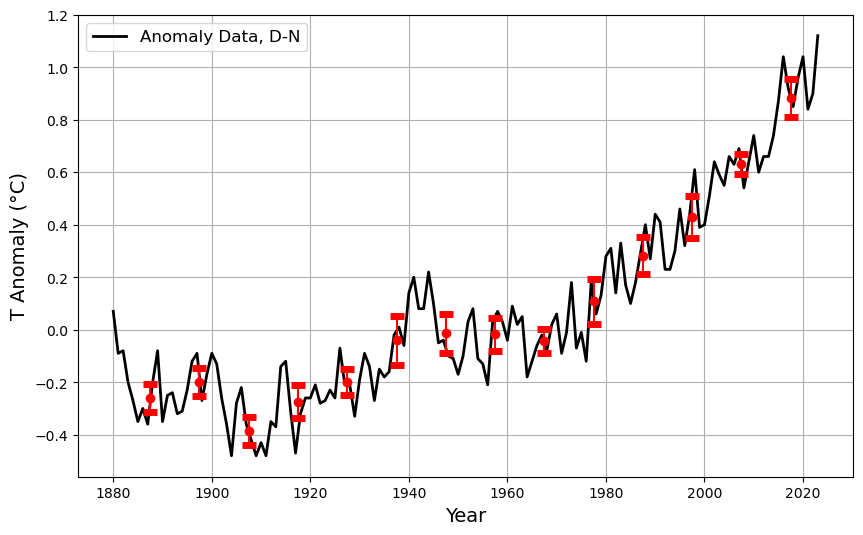

In [8]:
#TO-DO: change starting and ending years, as well as 
#       the column name here to be plotted here
start_year = [1880]  # more than one linear fit plotted max is 4
end_year = [2023]
#print('start_year 0',start_year[0])
column_name = 'D-N'
#print(start_year)
#print(end_year)
### Start by computing means and confidence limits for each decade


  
# define plot function   * * * * * 
def plot(start0, end0, dataframe, column, c, sig_level):  # this is copied from  process_giss_global_temp.py
    #check for correct year input
    minyr = dataframe.Year.min()
    maxyr = dataframe.Year.max()
    
    # check to see if start and end are vectors
    yr_sz = np.shape(start0)
   
    
    nn = yr_sz[0] 
    #print('nn',nn)
  
    start1 = (np.array(start0))
    end1 = (np.array(end0))
    for iy in range(0,nn):
        #print('iy',iy)
        
        #print('start1[iy]',start1[iy])
        start=int(start1[iy])
        end=int(end1[iy])
        #make sure input is in between correct years
        if np.logical_or(start<minyr, end>maxyr):
            print('Please enter integer years between 1880 and 2023!')
            return
    

        #create indexer array
        #tidx = np.logical_and(dataframe.Year >= start, dataframe.Year <= end)   # original
        tidx = np.logical_and(dataframe.Year >= start, dataframe.Year <= end)   # original
        decades = False
        if decades:
            tgap = 0  
            tend = -4
        else:
            tgap = 3  
            tend = -1
        print('tend ',tend)
        #subset for different times
        trend = dataframe[tidx]
        print('shape trend ',np.shape(trend))
        #calculate temperature anomaly here   # DLH why are we doing this??
        #anomaly = dataframe[column] - dataframe[column].mean()   # original
        anomaly = dataframe[column] # Try this Hey! that solved the bias problem
        anom = np.copy(anomaly[tgap:tend])
        yrs=len(anom)
        yrs2 = len(trend)
        print('years ',yrs,yrs2)
        
        time = dataframe.Year
        time1 = np.copy(time[tgap:tend])
        anom2 = np.copy(np.reshape(anom,(int(yrs/10),10)))
        time2 = np.copy(np.reshape(time1,(int(yrs/10),10)))
        # next take mean and std
        tmn = np.nanmean(time2,1)
        xmn = np.nanmean(anom2,1)
        xsd = np.nanstd(anom2,1,ddof=1)
        print('shape xsd ',np.shape(xsd))
        print('shape time2 ',np.shape(time2))
        print('tmn',tmn)
        q=0.95
        dof = 9
        tcrit = stats.t.ppf(q, dof)
        print('q,dof,tcrit',q,dof,tcrit)
        xlam = tcrit*xsd/np.sqrt(dof)
        
        #linear regressions
        x = trend.Year
        y = trend[column]
        
        m, b = np.polyfit(x, y, 1)

        #calculate residuals and autocorrelation
        n, vart, a0, a1, temp_res, residual, autocorr = calculate_res_autocorr(trend, column)

        #significance testing
        dof, sb, critical_t, low_t, high_t, delta_a, a1_t = calculate_significance(n, a0, a1, vart, autocorr, temp_res)
        a1_t = float(a1_t)

        iy = 0
        label = '{}-{} trends, {} significance, {:.3f} $\pm$ {:.3f}, DOF = {:.2f}'.format(start, end, sig_level, a1_t, delta_a, dof)
        if iy == 0:
            plt.plot(dataframe.Year, anomaly, color='k', linewidth=2, label='Anomaly Data, {}'.format(column))
            plt.errorbar(tmn, xmn, yerr=xlam,  fmt='o', capsize=5, capthick=5,color='r');
            #plt.plot(x, m*x+b, color=c, linewidth=2, label=label) 
        #label axes
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('T Anomaly ('+'\N{DEGREE SIGN}C)', fontsize=14)

        #add legend
        plt.legend(fontsize='large')
        #plt.show()
    
plt.figure(figsize=(10,6))
plot(start_year, end_year, df, column_name, deeppink, sig_level_string)
plt.grid()
plt.savefig('figures/552_GISS_Stats.pdf')
plt.savefig('figures/552_GISS_Stats.png')
plt.show()
